In [1]:
import numpy    as np
import torch.nn as nn
import torch
import json

from pymatgen.core        import Structure
from scipy.optimize       import minimize
from torch_geometric.data import Batch, Data
from libraries.model      import nGCNN, eGCNN, denoise, get_random_graph, add_features_to_graph
from libraries.dataset    import revert_standardize_dataset
from libraries.graph      import POSCAR_graph_encoding, graph_POSCAR_encoding, find_closest_key, composition_concentration_from_keys

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/claudio/cibran/Work/UPC/GenerativeModels/venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# From random noise, we generate completely new materials
# A target property can be seeked with this approach

In [3]:
# Define folder in which all data will be stored
is_molecule     = False
target_folder   = 'models/Loaded_QM9_gap-sphere-images/GM_v2'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

# Number of graphs to predict
N_predictions = 10

# Define target to be generated
target_tensor = torch.tensor(1, dtype=torch.int, device=device)

# Load model data

In [4]:
# Read the file in JSON format to a dictionary
with open(f'{target_folder}/model_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert torch tensors to numpy arrays
model_parameters = {}
for key, value in numpy_dict.items():
    try:
        model_parameters[key] = torch.tensor(value, device=device)
    except:
        model_parameters[key] = value

# Number of diffusing and denoising steps
n_t_steps = model_parameters['n_t_steps']

model_parameters['alpha_decay'] = torch.tensor(0.4, device=device)

# Decay of parameter alpha
alpha_decay = model_parameters['alpha_decay']

# Dropouts for node and edge models (independent of each other)
dropout_node = model_parameters['dropout_node']
dropout_edge = model_parameters['dropout_edge']

# Generation of graph database for training

Load the datasets, already standarized if possible.

In [5]:
dataset_name                = f'{target_folder}/dataset.pt'
labels_name                 = f'{target_folder}/standardized_labels.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

# Load the standardized dataset
dataset = torch.load(dataset_name_std)

# Read the file in JSON format to a dictionary
with open(dataset_parameters_name_std, 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert torch tensors to numpy arrays
dataset_parameters = {}
for key, value in numpy_dict.items():
    try:
        dataset_parameters[key] = torch.tensor(value, device=device)
    except:
        dataset_parameters[key] = value

/tmp/ipykernel_99667/933877349.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)


In [6]:
# Normalize target_tensor accordingly
target_tensor = (target_tensor - dataset_parameters['target_mean']) * dataset_parameters['scale'] / dataset_parameters['target_std']

In [7]:
# Calculate the mean and standard deviation of the number of nodes
total_nodes = torch.tensor([data.num_nodes for data in dataset])
mean_nodes  = torch.mean(total_nodes.float()).item()
std_nodes   = torch.std(total_nodes.float()).item()

mean_nodes, std_nodes

(17.983739852905273, 2.9542582035064697)

# Loading the model

In [8]:
# Determine number of node-level features in dataset, considering the t_step information
n_node_features = dataset[0].num_node_features

# Determine the number of graph-level features to be predicted
n_graph_features = len(dataset[0].y)

# Instantiate the models for nodes and edges
node_model = nGCNN(n_node_features, n_graph_features+1, dropout_node)
edge_model = eGCNN(n_node_features, n_graph_features+1, dropout_edge)

node_model.load_state_dict(torch.load(node_model_name, map_location=torch.device(device), weights_only=False))
edge_model.load_state_dict(torch.load(edge_model_name, map_location=torch.device(device), weights_only=False))
node_model.eval()
edge_model.eval()

# Allow data parallelization among multi-GPU
node_model= nn.DataParallel(node_model)
edge_model= nn.DataParallel(edge_model)

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
DataParallel(
  (module): nGCNN(
    (conv1): GraphConv(6, 256)
    (conv2): GraphConv(256, 512)
    (conv3): GraphConv(512, 256)
    (conv4): GraphConv(256, 4)
    (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

Edge GCNN:
DataParallel(
  (module): eGCNN(
    (linear1): Linear(in_features=7, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=64, bias=True)
    (linear4): Linear(in_features=64, out_features=1, bias=True)
    (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


# Generating new cystals

In [13]:
import seaborn as sns
sns.set_theme()

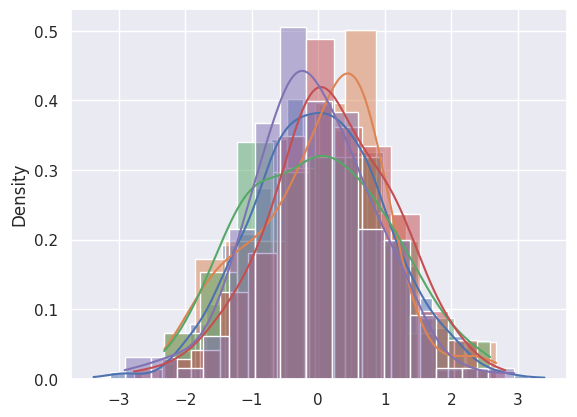

In [14]:
sns.histplot(diff_batch.edge_attr.cpu().numpy(), stat='density', kde=True)
for i in range(4):
    sns.histplot(diff_batch.x[:, i].cpu().numpy(), stat='density', kde=True)

In [9]:
# Create constant target tensor once
features_tensor = torch.tensor([target_tensor, 0], device=device)

# Predicting loop
diffused_dataset = []
with torch.no_grad():
    for idx in range(N_predictions):
        # Get a positive random number of nodes using absolute value
        n_nodes = int(np.abs(np.random.normal(mean_nodes, std_nodes)))
        
        # Get random graph, acting as diffused
        diffused_graph = get_random_graph(n_nodes, n_node_features)

        # Make room for n_graph_features and t_steps in the dataset
        diffused_graph = add_features_to_graph(diffused_graph, features_tensor)
        
        diffused_dataset.append(diffused_graph)
            
    # Generate batch object and move data to device
    diff_batch = Batch.from_data_list(diffused_dataset).to(device)
    
    # Denoise batch
    predicted_dataset = denoise(diff_batch, n_t_steps, node_model, edge_model, alpha_decay=alpha_decay,
                                sigma=model_parameters['sigma'], n_features=n_node_features)

# From batch object to list
predicted_dataset = predicted_dataset.to_data_list()

# Remove graph features
for graph in predicted_dataset:
    graph.x = graph.x[:, :n_node_features]

# Revert standardization
denoised_graphs = revert_standardize_dataset(predicted_dataset, dataset_parameters)
denoised_graphs


Step:  tensor(0, device='cuda:0')
Alpha:  tensor(0.6000, device='cuda:0') tensor(1.2910, device='cuda:0') tensor(0.8165, device='cuda:0')
tensor([[ 2.5666,  2.9049,  1.9242, -1.9788],
        [-1.8029,  0.8650, -0.5224, -1.1502],
        [-1.3211, -0.5446,  1.2300, -0.5628],
        [ 1.3827,  1.1377, -1.0693,  0.1675],
        [ 0.0365,  1.4409,  0.1448,  0.7628]], device='cuda:0')
Pred epsilon:  tensor([[ 1.4562,  0.0436,  1.5252, -0.6796],
        [ 1.8611,  0.2393,  0.9107,  0.7856],
        [ 1.2740,  0.1630,  1.3457, -0.5534],
        [ 0.0600,  1.7654,  1.1525, -0.3117],
        [ 1.4221, -0.1597,  1.4373, -0.7326]], device='cuda:0')
Resulting batch:  tensor([[-5.6001e-01, -1.1549e+00,  7.6964e-02,  1.9926e-01,  5.7667e+03,
         -5.0000e-01],
        [-8.9717e-01, -1.2877e+00, -1.4478e-01,  1.2621e+00,  5.7667e+03,
         -5.0000e-01],
        [-6.9578e-01, -1.1529e+00, -1.0158e-01,  2.8375e-01,  5.7667e+03,
         -5.0000e-01],
        [-1.4146e+00,  9.4067e-02, -6.418

[Data(x=[19, 4], edge_index=[2, 171], edge_attr=[171]),
 Data(x=[16, 4], edge_index=[2, 120], edge_attr=[120]),
 Data(x=[22, 4], edge_index=[2, 231], edge_attr=[231]),
 Data(x=[17, 4], edge_index=[2, 136], edge_attr=[136]),
 Data(x=[12, 4], edge_index=[2, 66], edge_attr=[66]),
 Data(x=[14, 4], edge_index=[2, 91], edge_attr=[91]),
 Data(x=[18, 4], edge_index=[2, 153], edge_attr=[153]),
 Data(x=[17, 4], edge_index=[2, 136], edge_attr=[136]),
 Data(x=[13, 4], edge_index=[2, 78], edge_attr=[78]),
 Data(x=[19, 4], edge_index=[2, 171], edge_attr=[171])]

In [10]:
temp = denoised_graphs[0]

nodes = temp.x
edges = temp.edge_index.detach().cpu().numpy().T
weights = temp.edge_attr.detach().cpu().numpy()

## Molecules

In [12]:
if is_molecule:
    # Initial guess for the positions
    solution = np.random.rand(len(nodes) * 3)*10  # Initialize all points at origin, 1D array
    #solution = coordinates.reshape(-1, 1).ravel()
    
    # Function to calculate the squared difference between distances and weights
    def objective(solution_attempt, edges, weights):
        positions = solution_attempt.reshape(-1, 3)  # Reshape to 2D array
        errors = 0
        for edge, weight in zip(edges, weights):
            p1 = positions[edge[0]]
            p2 = positions[edge[1]]
            distance = np.linalg.norm(p2 - p1)
            errors += np.power(distance - weight, 2)
        #print(errors)
        return errors
    
    def worst_identification(edges, attributes, solution_attempt):
        positions = solution_attempt.reshape(-1, 3)  # Reshape to 2D array
    
        particle_errors = []
        for particle in np.unique(edges):
            # Get those edge indexes where particle has a connection
            particle_connections = np.where((edges[:, 0] == particle) | (edges[:, 1] == particle))
    
            particle_error = 0
            for idx in particle_connections[0]:
                # Load indexes in edge
                edge = edges[idx]
    
                # Load expected attribute
                p1 = positions[edge[0]]
                p2 = positions[edge[1]]
    
                # Load reference attribute
                weight = attributes[idx].item()
                
                # Compute error
                distance = np.linalg.norm(p2 - p1)

                # Append to trial errors for different atom images
                trial_error = np.power(distance - weight, 2)
    
                # Add error
                particle_error += trial_error
    
            # Average over the connection of the node
            particle_error /= len(particle_connections[0])
    
            # Append particle error
            particle_errors.append(particle_error)
    
        return np.argmax(particle_errors), np.max(particle_errors)

## Crystals

In [13]:
if not is_molecule:
    # Initial guess for the lattice parameters
    lattice_vectors = np.array([[10, 0,   0],
                                [0,   10, 0],
                                [0,   0,   10]])
    
    # Initial guess for the positions
    initial_positions = np.random.rand(len(nodes) * 3)  # Initialize all points at origin, 1D array
    #initial_positions = coordinates.reshape(-1, 1).ravel()
    solution = np.concatenate([lattice_vectors.ravel(), initial_positions])
    
    # Function to calculate the squared difference between distances and weights
    def objective(solution_attempt, edges, weights):
        solution_attempt = solution_attempt.reshape(-1, 3)  # Reshape to 2D array
        
        lattice_vectors = solution_attempt[:3]
        positions       = solution_attempt[3:]
        
        errors = 0
        for edge, weight in zip(edges, weights):
            p1 = positions[edge[0]]
            p2 = positions[edge[1]]
            
            trial_errors = [] 
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    for k in [-1, 0, 1]:
                        # i*lattice_vectors[0] + j*lattice_vectors[1] + k*lattice_vectors[2]
                        ijk_lattice_vectors = np.sum([i, j, k] * lattice_vectors.T, axis=1)

                        # Compute error
                        distance = np.linalg.norm(p2 - p1 + ijk_lattice_vectors)

                        # Append to trial errors for differente atom images
                        trial_errors.append(np.power(distance - weight, 2))
            errors += np.min(trial_errors)
        #print(errors)
        return errors
    
    def worst_identification(edges, attributes, solution_attempt):
        solution_attempt = solution_attempt.reshape(-1, 3)  # Reshape to 2D array
    
        lattice_vectors = solution_attempt[:3]
        positions       = solution_attempt[3:]
    
        particle_errors = []
        for particle in np.unique(edges):
            # Get those edge indexes where particle has a connection
            particle_connections = np.where((edges[:, 0] == particle) | (edges[:, 1] == particle))
    
            particle_error = 0
            for idx in particle_connections[0]:
                # Load indexes in edge
                edge = edges[idx]
    
                # Load expected attribute
                p1 = positions[edge[0]]
                p2 = positions[edge[1]]
    
                # Load reference attribute
                weight = attributes[idx].item()
    
                trial_errors = []
                for i in [-1, 0, 1]:
                    for j in [-1, 0, 1]:
                        for k in [-1, 0, 1]:
                            # i*lattice_vectors[0] + j*lattice_vectors[1] + k*lattice_vectors[2]
                            ijk_lattice_vectors = np.sum([i, j, k] * lattice_vectors.T, axis=1)
    
                            # Compute error
                            distance = np.linalg.norm(p2 - p1 + ijk_lattice_vectors)
    
                            # Append to trial errors for different atom images
                            trial_errors.append(np.power(distance - weight, 2))
    
                # Add error
                particle_error += np.min(trial_errors)
    
            # Average over the connection of the node
            particle_error /= len(particle_connections[0])
    
            # Append particle error
            particle_errors.append(particle_error)
    
        return np.argmax(particle_errors), np.max(particle_errors)

In [14]:
error_threshold = 1e-5

for attempt in range(100):
    print()
    print(f'Attempt {attempt}')
    solution = minimize(objective, solution,
                        args=(edges, weights),
                        method='Powell')

    is_success       = solution.success
    solution_message = solution.message
    worst_particle, worst_error = worst_identification(edges, weights, solution.x)

    attempt_error = objective(solution.x, edges, weights)
    print(f'Total: {attempt_error} and local {worst_error} errors')

    if attempt_error < error_threshold:
        break

    solution = solution.x.reshape(-1, 3)  # Reshape to 2D array

    # Re-initialize that position
    if is_molecule:
        solution[worst_particle] = np.random.rand(3)
    else:
        solution[worst_particle+3] = np.random.rand(3)

    solution = solution.flatten()

# Check convergence status
if is_success:
    print('Converged to a solution.')
else:
    print(f'Failed to converge: {solution_message}')


Attempt 0
Total: 109.87638410004433 and local 0.7235525572033047 errors

Attempt 1
Total: 109.94789570923339 and local 0.7267014780141707 errors

Attempt 2
Total: 109.89995233490441 and local 0.7228179915015176 errors

Attempt 3
Total: 109.88679338793916 and local 0.7240374708545738 errors

Attempt 4
Total: 109.93015668648557 and local 0.7261723052134357 errors

Attempt 5
Total: 109.87679370188496 and local 0.7248992777977689 errors

Attempt 6
Total: 109.93114896602168 and local 0.72611697416587 errors

Attempt 7
Total: 109.88875323916463 and local 0.7250824500942431 errors

Attempt 8
Total: 110.16947113509427 and local 0.7365660549775519 errors

Attempt 9
Total: 109.92532154678788 and local 0.7252832039795168 errors

Attempt 10
Total: 109.86127211979566 and local 0.7242764620127184 errors

Attempt 11
Total: 110.18394283581172 and local 0.7380528973735023 errors

Attempt 12
Total: 109.93200312362731 and local 0.7250786212841855 errors

Attempt 13
Total: 109.87418186926864 and local 0.

In [15]:
solution = solution.reshape(-1, 3)

## Molecules

In [16]:
if is_molecule:
    # Get the position of each atom in direct coordinates
    #direct_positions = graph_to_cartesian_positions(graph)
    #cartesian_positions = solution.x.reshape(-1, 3)*mw
    #cartesian_positions = solution.x.reshape(-1, 3)
    
    lattice_vectors     = np.array([[10,  0,   0],
                                    [0,   10,  0],
                                    [0,   0,   10]])
    cartesian_positions = solution

## Crystals

In [17]:
if not is_molecule:
    # Get the position of each atom in direct coordinates
    #direct_positions = graph_to_cartesian_positions(graph)
    #cartesian_positions = solution.x.reshape(-1, 3)*mw
    
    lattice_vectors     = solution[:3]
    cartesian_positions = solution[3:]

In [18]:
POSCAR_name = None

# Get name for the first line of the POSCAR
POSCAR_name = POSCAR_name or 'POSCAR from GenerativeModels'

# Clone the input graph to preserve the original structure
new_graph = temp.clone()

# Load and detach embeddings for the graph nodes
data_embeddings = new_graph.x.detach().cpu().numpy()

# Loading dictionary of available embeddings for atoms
available_embeddings = {}
with open('../MP/input/atomic_masses.dat', 'r') as atomic_masses_file:
    for line in atomic_masses_file:
        key, mass, charge, electronegativity, ionization_energy = line.split()

        # Check if all information is present
        if all(val != 'None' for val in (mass, charge, electronegativity, ionization_energy)):
            available_embeddings[key] = np.array([mass, charge, electronegativity, ionization_energy], dtype=float)

# Get most similar atoms for each graph node and create a list of keys
keys = [find_closest_key(available_embeddings, emb) for emb in data_embeddings]

# Get elements' composition, concentration, and positions
POSCAR_composition, POSCAR_concentration, POSCAR_positions = composition_concentration_from_keys(keys, cartesian_positions)

In [19]:
# Write file
with open('CONTCAR', 'w') as POSCAR_file:
    # Delete previous data in the file
    POSCAR_file.truncate()
    
    # Write POSCAR's name
    POSCAR_file.write(f'{POSCAR_name}\n')

    # Write scaling factor (assumed to be 1.0)
    POSCAR_file.write('1.0\n')

    # Write lattice parameters (assumed to be orthogonal)
    np.savetxt(POSCAR_file, lattice_vectors, delimiter=' ')

    # Write composition (each different species, previously sorted)
    np.savetxt(POSCAR_file, [POSCAR_composition], fmt='%s', delimiter=' ')

    # Write concentration (number of each of the previous elements)
    np.savetxt(POSCAR_file, [POSCAR_concentration], fmt='%d', delimiter=' ')

    # Write position in cartesian form
    POSCAR_file.write('Cartesian\n')
    np.savetxt(POSCAR_file, POSCAR_positions, delimiter=' ')